# CocomoNasaV1

In [1]:
dataset = "cocomonasav1_pre"

time: 1.03 ms


## Rohe Daten
Baue Datenbankverbindung auf und zeige 3 Beispieldaten aus dem vorbereiteten Datensatz "Desharnais".

In [2]:
from libs.data.Db import Db
import pandas as pd

db = Db().getDb()
desh = db[dataset]

data = pd.DataFrame(
    list(desh.find({}, { 'id': 0, '_id': 0 }))
)

list(desh.find().limit(3))

[{'_id': ObjectId('5cae65c61b21430025242c5e'),
  'ACT_EFFORT': 278.0,
  'id': 1.0,
  'LOC': -0.04761711067290769,
  'Is_RELY_VeryLow': 0.0,
  'Is_RELY_Low': -0.13018891098082386,
  'Is_RELY_Nominal': 0.9672041516493515,
  'Is_RELY_High': -0.8744746321952062,
  'Is_RELY_VeryHigh': -0.1856953381770519,
  'Is_RELY_ExtraHigh': 0.0,
  'Is_DATA_VeryLow': 0.0,
  'Is_DATA_Low': -0.9354143466934852,
  'Is_DATA_Nominal': -0.6030226891555271,
  'Is_DATA_High': 2.3804761428476167,
  'Is_DATA_VeryHigh': -0.36342189215581544,
  'Is_DATA_ExtraHigh': 0.0,
  'Is_CPLX_VeryLow': 0.0,
  'Is_CPLX_Low': -0.18569533817705186,
  'Is_CPLX_Nominal': -0.30151134457776363,
  'Is_CPLX_High': -2.2360679774997894,
  'Is_CPLX_VeryHigh': 5.385164807134505,
  'Is_CPLX_ExtraHigh': -0.13018891098082386,
  'Is_TIME_VeryLow': 0.0,
  'Is_TIME_Low': 0.0,
  'Is_TIME_Nominal': 0.7071067811865476,
  'Is_TIME_High': -0.3634218921558155,
  'Is_TIME_VeryHigh': -0.49999999999999994,
  'Is_TIME_ExtraHigh': -0.13018891098082386,
  'I

time: 1.26 s


### Data

In [3]:
import pandas as pd

X_data = pd.DataFrame(
    list(desh.find({}, { 'ACT_EFFORT': 0, 'id': 0, '_id': 0 }))
)
y_data = pd.DataFrame(
    list(desh.find({}, { 'ACT_EFFORT': 1, '_id': 0 }))
)
header = list(X_data.columns.values)

time: 30.7 ms


Funktion zum Berechnen der Baumtiefe

In [4]:
def dectree_max_depth(tree):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

time: 1.99 ms


# Multirun

In [5]:
from sklearn.model_selection import train_test_split
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from libs.tree.ModelTree import ModelTree
from sklearn.ensemble import RandomForestRegressor
from libs.forest.RandomForestModelTree import RandomForestModelTree
from sklearn.metrics import make_scorer
from datetime import datetime
import pandas as pd
import numpy as np
import os
import time

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

X = X_data.values
y = np.ravel(y_data.values.astype('float')) # scikit needs to know what kind of problem to solve

n_runs = 30
m_dt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_mt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfdt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
m_rfmt = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
for i in range(n_runs):
    print("{}/{}".format(i+1, n_runs))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    searchSpace_trees = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }
    
    searchSpace_forests = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 18, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(header)+1),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None], # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        "bootstrap": [True, False],
        #"oob_score": [True],
        "n_estimators": [20],
        "n_jobs": [-1]
    }
    
    #--------------------------
    print("DT")
    start_time = time.clock()
    
    rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_dt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_dt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_dt.best_params_["criterion"],
            max_depth = rs_dt.best_params_["max_depth"],
            min_samples_split = rs_dt.best_params_["min_samples_split"],
            min_samples_leaf = rs_dt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_dt.best_params_["max_leaf_nodes"],
            max_features = rs_dt.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(dt.tree_)))

    m_dt['mmre'].append(np.mean(mmres))
    m_dt['mdmre'].append(np.mean(mdmres))
    m_dt['pred'].append(np.mean(preds))
    m_dt['mmer'].append(np.mean(mmers))
    m_dt['mdmer'].append(np.mean(mdmers))
    m_dt['mae'].append(np.mean(maes))
    m_dt['mbre'].append(np.mean(mbres))
    m_dt['mibre'].append(np.mean(mibres))
    m_dt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("MT")
    start_time = time.clock()
    
    rs_mt = RandomizedSearchCV(ModelTree(), searchSpace_trees, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_mt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_mt.best_params_))
    
    mmres_mt = []
    mdmres_mt = []
    preds_mt = []
    mmers_mt = []
    mdmers_mt = []
    maes_mt = []
    mbres_mt = []
    mibres_mt = []
    sas_mt = []
    for i in range(1):
        mt = ModelTree(
            criterion = rs_mt.best_params_["criterion"],
            max_depth = rs_mt.best_params_["max_depth"],
            min_samples_split = rs_mt.best_params_["min_samples_split"],
            min_samples_leaf = rs_mt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_mt.best_params_["max_leaf_nodes"],
            max_features = rs_mt.best_params_["max_features"]
        )
        mt.fit(X_train, y_train)
        y_pred = mt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_mt.append(metrics['mmre'])
        mdmres_mt.append(metrics['mdmre'])
        preds_mt.append(metrics['pred'])
        mmers_mt.append(metrics['mmer'])
        mdmers_mt.append(metrics['mdmer'])
        maes_mt.append(metrics['mae'])
        mbres_mt.append(metrics['mbre'])
        mibres_mt.append(metrics['mibre'])
        sas_mt.append(metrics['sa'])
        print("Tree-depth: {}".format(dectree_max_depth(mt.tree_)))

    m_mt['mmre'].append(np.mean(mmres_mt))
    m_mt['mdmre'].append(np.mean(mdmres_mt))
    m_mt['pred'].append(np.mean(preds_mt))
    m_mt['mmer'].append(np.mean(mmers_mt))
    m_mt['mdmer'].append(np.mean(mdmers_mt))
    m_mt['mae'].append(np.mean(maes_mt))
    m_mt['mbre'].append(np.mean(mbres_mt))
    m_mt['mibre'].append(np.mean(mibres_mt))
    m_mt['sa'].append(np.mean(sas_mt))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFDT")
    start_time = time.clock()
    
    rs_rfdt = RandomizedSearchCV(RandomForestRegressor(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfdt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfdt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfdt = RandomForestRegressor(
            criterion = rs_rfdt.best_params_["criterion"],
            max_depth = rs_rfdt.best_params_["max_depth"],
            min_samples_split = rs_rfdt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfdt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfdt.best_params_["max_leaf_nodes"],
            max_features = rs_rfdt.best_params_["max_features"],
            bootstrap = rs_rfdt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfdt.fit(X_train, y_train)
        y_pred = rfdt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])

    m_rfdt['mmre'].append(np.mean(mmres))
    m_rfdt['mdmre'].append(np.mean(mdmres))
    m_rfdt['pred'].append(np.mean(preds))
    m_rfdt['mmer'].append(np.mean(mmers))
    m_rfdt['mdmer'].append(np.mean(mdmers))
    m_rfdt['mae'].append(np.mean(maes))
    m_rfdt['mbre'].append(np.mean(mbres))
    m_rfdt['mibre'].append(np.mean(mibres))
    m_rfdt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))
    
    #--------------------------
    print("RFMT")
    start_time = time.clock()
    
    rs_rfmt = RandomizedSearchCV(RandomForestModelTree(), searchSpace_forests, n_iter=100, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False, error_score=0.0)
    rs_rfmt.fit(X_train, y_train)
    mid_time = time.clock()
    print("best params: {}".format(rs_rfmt.best_params_))

    mmres = []
    mdmres = []
    preds = []
    mmers = []
    mdmers = []
    maes = []
    mbres = []
    mibres = []
    sas = []
    for i in range(1):
        rfmt = RandomForestModelTree(
            criterion = rs_rfmt.best_params_["criterion"],
            max_depth = rs_rfmt.best_params_["max_depth"],
            min_samples_split = rs_rfmt.best_params_["min_samples_split"],
            min_samples_leaf = rs_rfmt.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_rfmt.best_params_["max_leaf_nodes"],
            max_features = rs_rfmt.best_params_["max_features"],
            bootstrap = rs_rfmt.best_params_["bootstrap"],
            n_estimators = 1000
        )
        rfmt.fit(X_train, y_train)
        y_pred = rfmt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres.append(metrics['mmre'])
        mdmres.append(metrics['mdmre'])
        preds.append(metrics['pred'])
        mmers.append(metrics['mmer'])
        mdmers.append(metrics['mdmer'])
        maes.append(metrics['mae'])
        mbres.append(metrics['mbre'])
        mibres.append(metrics['mibre'])
        sas.append(metrics['sa'])

    m_rfmt['mmre'].append(np.mean(mmres))
    m_rfmt['mdmre'].append(np.mean(mdmres))
    m_rfmt['pred'].append(np.mean(preds))
    m_rfmt['mmer'].append(np.mean(mmers))
    m_rfmt['mdmer'].append(np.mean(mdmers))
    m_rfmt['mae'].append(np.mean(maes))
    m_rfmt['mbre'].append(np.mean(mbres))
    m_rfmt['mibre'].append(np.mean(mibres))
    m_rfmt['sa'].append(np.mean(sas))
    end_time = time.clock()
    print("time: {} (HT: {})".format(end_time-start_time, mid_time-start_time))

print("DT:")
print("MMRE: {}\n{}".format(np.mean(m_dt['mmre']), m_dt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_dt['mdmre']), m_dt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_dt['pred']), m_dt['pred']))
print("MMER: {}\n{}".format(np.mean(m_dt['mmer']), m_dt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_dt['mdmer']), m_dt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_dt['mae']), m_dt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_dt['mbre']), m_dt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_dt['mibre']), m_dt['mibre']))
print("SA: {}\n{}".format(np.mean(m_dt['sa']), m_dt['sa']))
print("------------------------------------------------")
print("MT:")
print("MMRE: {}\n{}".format(np.mean(m_mt['mmre']), m_mt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_mt['mdmre']), m_mt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_mt['pred']), m_mt['pred']))
print("MMER: {}\n{}".format(np.mean(m_mt['mmer']), m_mt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_mt['mdmer']), m_mt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_mt['mae']), m_mt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_mt['mbre']), m_mt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_mt['mibre']), m_mt['mibre']))
print("SA: {}\n{}".format(np.mean(m_mt['sa']), m_mt['sa']))
print("------------------------------------------------")
print("RFDT:")
print("MMRE: {}\n{}".format(np.mean(m_rfdt['mmre']), m_rfdt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfdt['mdmre']), m_rfdt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfdt['pred']), m_rfdt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfdt['mmer']), m_rfdt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfdt['mdmer']), m_rfdt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfdt['mae']), m_rfdt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfdt['mbre']), m_rfdt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfdt['mibre']), m_rfdt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfdt['sa']), m_rfdt['sa']))
print("------------------------------------------------")
print("RFMT:")
print("MMRE: {}\n{}".format(np.mean(m_rfmt['mmre']), m_rfmt['mmre']))
print("MDMRE: {}\n{}".format(np.mean(m_rfmt['mdmre']), m_rfmt['mdmre']))
print("PRED: {}\n{}".format(np.mean(m_rfmt['pred']), m_rfmt['pred']))
print("MMER: {}\n{}".format(np.mean(m_rfmt['mmer']), m_rfmt['mmer']))
print("MDMER: {}\n{}".format(np.mean(m_rfmt['mdmer']), m_rfmt['mdmer']))
print("MAE: {}\n{}".format(np.mean(m_rfmt['mae']), m_rfmt['mae']))
print("MBRE: {}\n{}".format(np.mean(m_rfmt['mbre']), m_rfmt['mbre']))
print("MIBRE: {}\n{}".format(np.mean(m_rfmt['mibre']), m_rfmt['mibre']))
print("SA: {}\n{}".format(np.mean(m_rfmt['sa']), m_rfmt['sa']))
print("------------------------------------------------")

1/30
DT
best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 5, 'max_features': 59, 'max_depth': 18, 'criterion': 'mse'}
cocomonasav1_pre_1554933272981.csv
Tree-depth: 3
time: 6.107404000000001 (HT: 6.081800000000001)
MT
best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 20, 'max_features': 42, 'max_depth': 19, 'criterion': 'mse'}
cocomonasav1_pre_1554933283300.csv
Tree-depth: 6
time: 5.747465999999999 (HT: 5.675004999999999)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 5, 'max_features': 87, 'max_depth': 8, 'criterion': 'mae', 'bootstrap': True}
cocomonasav1_pre_1554933675999.csv
time: 35.486342 (HT: 32.524954)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_leaf_nodes': None, 'max_features': 80, 'max_depth': 7, 'criterion': 'mae', 'bootstrap': False}
cocomonasav1_pre_1554934256080.csv
t

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 20, 'max_features': 72, 'max_depth': 2, 'criterion': 'mae', 'bootstrap': False}
cocomonasav1_pre_1554941158855.csv
time: 42.624063999999976 (HT: 35.32882700000005)
9/30
DT
best params: {'min_samples_split': 0.15, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 20, 'max_features': 78, 'max_depth': 16, 'criterion': 'mse'}
cocomonasav1_pre_1554941172588.csv
Tree-depth: 8
time: 6.535337000000027 (HT: 6.496231999999964)
MT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.05, 'max_leaf_nodes': None, 'max_features': 52, 'max_depth': 9, 'criterion': 'mse'}
cocomonasav1_pre_1554941183537.csv
Tree-depth: 7
time: 6.483099000000038 (HT: 6.4430340000000115)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.15, 'max_leaf_nodes': 5, 'max_features': 84, 'max_depth': 5, 'criterion': 'mse', 'bootstrap': True}
cocomonasav1_pre_15

best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.1, 'min_samples_leaf': 0.4, 'max_leaf_nodes': 5, 'max_features': 80, 'max_depth': 12, 'criterion': 'mae', 'bootstrap': False}
cocomonasav1_pre_1554948428907.csv
time: 34.49596699999984 (HT: 32.698122999999896)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.3, 'min_samples_leaf': 0.05, 'max_leaf_nodes': None, 'max_features': 70, 'max_depth': 18, 'criterion': 'mse', 'bootstrap': True}
cocomonasav1_pre_1554948995512.csv
time: 42.56019900000001 (HT: 35.85657900000001)
17/30
DT
best params: {'min_samples_split': 0.05, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 5, 'max_features': 90, 'max_depth': 14, 'criterion': 'mae'}
cocomonasav1_pre_1554949008655.csv
Tree-depth: 4
time: 6.445083000000068 (HT: 6.423132000000123)
MT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 65, 'max_depth': 16, 'criterion': 'mse'}
cocomonasav1_pre_1554949020303.csv

best params: {'min_samples_split': 0.1, 'min_samples_leaf': 0.2, 'max_leaf_nodes': 10, 'max_features': 75, 'max_depth': 3, 'criterion': 'mae'}
cocomonasav1_pre_1554955796889.csv
Tree-depth: 4
time: 7.678106999999727 (HT: 7.649136999999882)
RFDT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 15, 'max_features': 74, 'max_depth': 6, 'criterion': 'mse', 'bootstrap': False}
cocomonasav1_pre_1554956191364.csv
time: 33.882010000000264 (HT: 32.33154800000011)
RFMT
best params: {'n_jobs': -1, 'n_estimators': 20, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 20, 'max_features': 78, 'max_depth': 3, 'criterion': 'mse', 'bootstrap': True}
cocomonasav1_pre_1554956735142.csv
time: 42.16005700000005 (HT: 35.15906100000029)
25/30
DT
best params: {'min_samples_split': 0.2, 'min_samples_leaf': 0.05, 'max_leaf_nodes': 15, 'max_features': 63, 'max_depth': 9, 'criterion': 'mse'}
cocomonasav1_pre_1554956748385.csv
Tr

## Vergleich

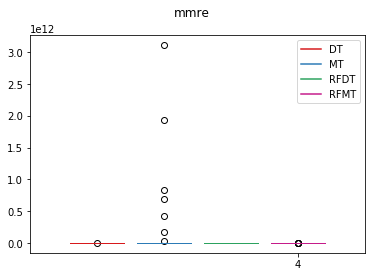

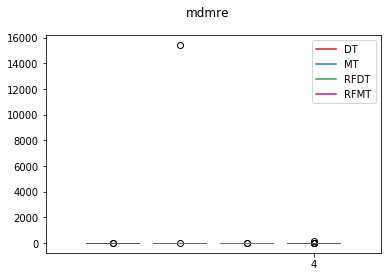

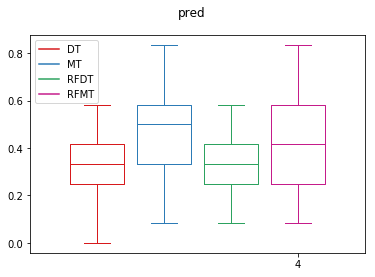

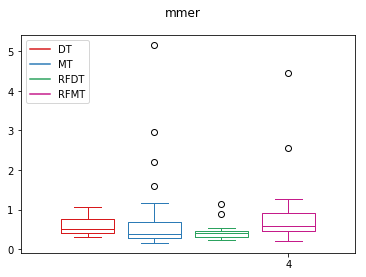

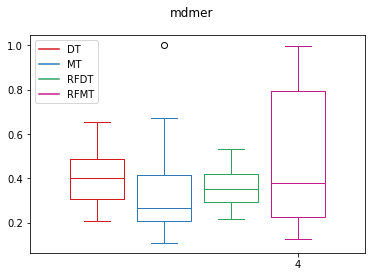

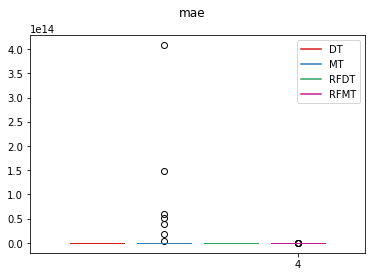

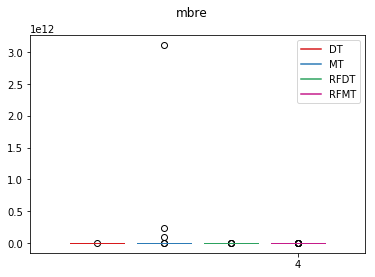

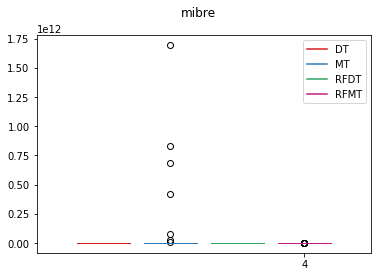

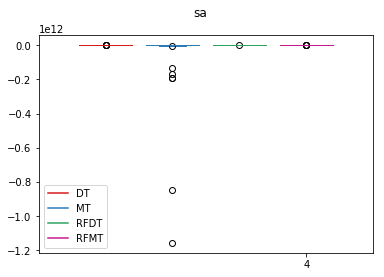

time: 2.59 s


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']

for item in ticks:
    fig, ax = plt.subplots()
    fig.suptitle("{}".format(item))
    bpll = ax.boxplot(m_dt[item], positions=[1], widths=0.8)
    bplr = ax.boxplot(m_mt[item], positions=[2], widths=0.8)
    bprl = ax.boxplot(m_rfdt[item], positions=[3], widths=0.8)
    bprr = ax.boxplot(m_rfmt[item], positions=[4], widths=0.8)
    set_box_color(bpll, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bplr, '#2C7BB6')
    set_box_color(bprl, '#2CA25F')
    set_box_color(bprr, '#C51B8A')
    ax.plot([], c='#D7191C', label='DT')
    ax.plot([], c='#2C7BB6', label='MT')
    ax.plot([], c='#2CA25F', label='RFDT')
    ax.plot([], c='#C51B8A', label='RFMT')
    ax.legend()
    plt.xlim(0, 5)

plt.show()

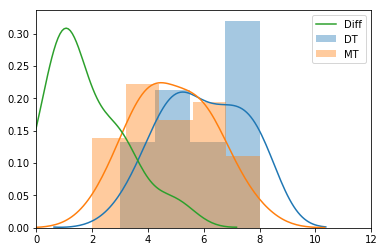

time: 820 ms


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tree_sizes = [[3, 6], [4, 5], [5, 6], [6, 5], [7, 7], [8, 3], [8, 8], [5, 4], [8, 7], [4, 4],
              [5, 4], [5, 3], [8, 6], [7, 3], [5, 6], [6, 4], [4, 7], [8, 5], [6, 5], [5, 4],
              [8, 5], [7, 4], [7, 4], [6, 4], [7, 6], [5, 6], [5, 6], [4, 3], [7, 2], [6, 5],
]

dt_sizes = [i[0] for i in tree_sizes]
mt_sizes = [i[1] for i in tree_sizes]
diff_sizes = [np.abs(i[0]-i[1]) for i in tree_sizes]

sns.distplot(dt_sizes, label="DT")
sns.distplot(mt_sizes, label="MT")
sns.distplot(diff_sizes, hist=False, label="Diff")

plt.xlim(0, 12)
plt.legend()
plt.show()

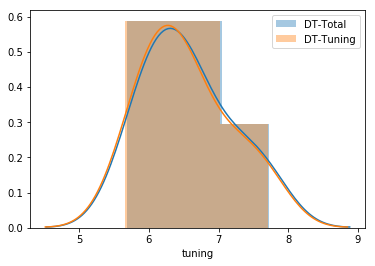

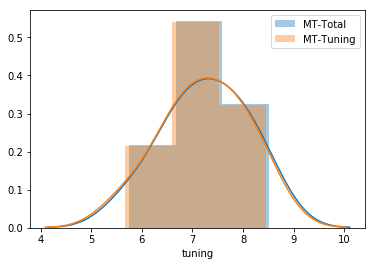

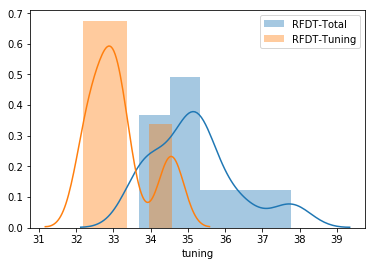

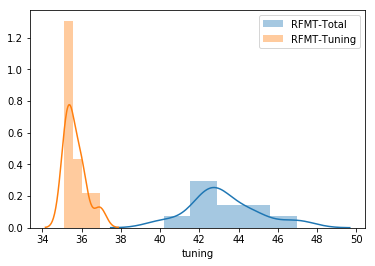

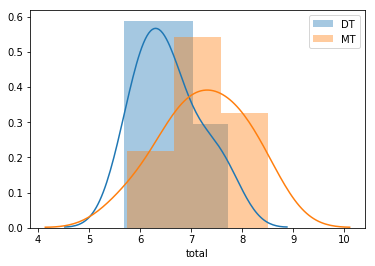

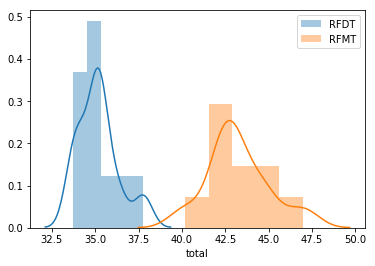

time: 5.74 s


In [47]:
import pandas as pd

times = pd.DataFrame([
    {'method': 'dt', 'total': 6.107404000000001, 'tuning': 6.081800000000001},
    {'method': 'dt', 'total': 6.550308000000001, 'tuning': 6.49598499999999},
    {'method': 'dt', 'total': 6.995689999999996, 'tuning': 6.970824999999991},
    {'method': 'dt', 'total': 7.723528999999985, 'tuning': 7.70163100000002},
    {'method': 'dt', 'total': 6.105710999999985, 'tuning': 6.07960300000002},
    {'method': 'dt', 'total': 6.000304000000028, 'tuning': 5.980880000000013},
    {'method': 'dt', 'total': 7.3526860000000624, 'tuning': 7.3229840000000195},
    {'method': 'dt', 'total': 6.520306000000005, 'tuning': 6.496144999999956},
    {'method': 'dt', 'total': 6.535337000000027, 'tuning': 6.496231999999964},
    {'method': 'dt', 'total': 5.684611000000018, 'tuning': 5.661031000000094},
    
    {'method': 'mt', 'total': 5.747465999999999, 'tuning': 5.675004999999999},
    {'method': 'mt', 'total': 8.506495999999999, 'tuning': 8.457104999999999},
    {'method': 'mt', 'total': 7.5315490000000125, 'tuning': 7.498635000000007},
    {'method': 'mt', 'total': 7.511912999999993, 'tuning': 7.482703000000015},
    {'method': 'mt', 'total': 7.170182000000011, 'tuning': 7.140547000000026},
    {'method': 'mt', 'total': 6.697609, 'tuning': 6.671986000000004},
    {'method': 'mt', 'total': 8.174726000000078, 'tuning': 8.138069000000087},
    {'method': 'mt', 'total': 7.919639000000075, 'tuning': 7.880365999999981},
    {'method': 'mt', 'total': 6.483099000000038, 'tuning': 6.4430340000000115},
    {'method': 'mt', 'total': 6.8854820000000245, 'tuning': 6.854231000000027},
    
    {'method': 'rfdt', 'total': 35.486342, 'tuning': 32.524954},
    {'method': 'rfdt', 'total': 36.35685999999998, 'tuning': 34.558632999999986},
    {'method': 'rfdt', 'total': 37.76848099999998, 'tuning': 34.54056},
    {'method': 'rfdt', 'total': 35.16512599999999, 'tuning': 33.08537000000001},
    {'method': 'rfdt', 'total': 33.69544300000001, 'tuning': 32.18962600000003},
    {'method': 'rfdt', 'total': 33.86438599999997, 'tuning': 32.334667999999965},
    {'method': 'rfdt', 'total': 35.30786599999999, 'tuning': 33.335083000000054},
    {'method': 'rfdt', 'total': 35.10538900000006, 'tuning': 32.96407099999999},
    {'method': 'rfdt', 'total': 34.206282999999985, 'tuning': 32.76878799999997},
    {'method': 'rfdt', 'total': 34.90974600000004, 'tuning': 33.01427899999999},
    
    {'method': 'rfmt', 'total': 43.250251000000006, 'tuning': 36.03416300000001},
    {'method': 'rfmt', 'total': 44.80921700000002, 'tuning': 36.929137999999995},
    {'method': 'rfmt', 'total': 46.96974899999998, 'tuning': 35.98349999999999},
    {'method': 'rfmt', 'total': 42.264905, 'tuning': 35.31945200000001},
    {'method': 'rfmt', 'total': 40.17480699999999, 'tuning': 35.094330000000014},
    {'method': 'rfmt', 'total': 44.47319500000003, 'tuning': 35.86265900000001},
    {'method': 'rfmt', 'total': 42.97115700000006, 'tuning': 35.437501},
    {'method': 'rfmt', 'total': 42.624063999999976, 'tuning': 35.32882700000005},
    {'method': 'rfmt', 'total': 42.2042439999999, 'tuning': 35.37542799999994},
    {'method': 'rfmt', 'total': 42.677954, 'tuning': 35.27372199999991}
])

dt_times = times[times['method'] == 'dt']
mt_times = times[times['method'] == 'mt']
rfdt_times = times[times['method'] == 'rfdt']
rfmt_times = times[times['method'] == 'rfmt']

sns.distplot(dt_times['total'], label="DT-Total")
sns.distplot(dt_times['tuning'], label="DT-Tuning")
plt.legend()
plt.show()

sns.distplot(mt_times['total'], label="MT-Total")
sns.distplot(mt_times['tuning'], label="MT-Tuning")
plt.legend()
plt.show()

sns.distplot(rfdt_times['total'], label="RFDT-Total")
sns.distplot(rfdt_times['tuning'], label="RFDT-Tuning")
plt.legend()
plt.show()

sns.distplot(rfmt_times['total'], label="RFMT-Total")
sns.distplot(rfmt_times['tuning'], label="RFMT-Tuning")
plt.legend()
plt.show()

sns.distplot(dt_times['total'], label="DT")
sns.distplot(mt_times['total'], label="MT")
plt.legend()
plt.show()

sns.distplot(rfdt_times['total'], label="RFDT")
sns.distplot(rfmt_times['total'], label="RFMT")
plt.legend()
plt.show()

## LaTeX-Tabelle

In [7]:
methods = ['dt', 'mt', 'rfdt', 'rfmt']
greater_is_better = [False, False, True, False, False, False, False, False, True]
ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']
for j, t in enumerate(ticks):
    values = []
    values.append(np.mean(m_dt[t]))
    values.append(np.mean(m_mt[t]))
    values.append(np.mean(m_rfdt[t]))
    values.append(np.mean(m_rfmt[t]))
    values_s = sorted(values, reverse = greater_is_better[j])
    rank = {}
    for i, method in enumerate(methods):
        c = values.index(values_s[i])
        rank[methods[c]] = i
        
    print("\t{}".format(t.upper()), end='', flush=True)
    for i, method in enumerate(methods):
        print(" & \cellcolor{{gr0{}}} {:.4f}".format(rank[method]+1, values[i]), end='', flush=True)
        
    print(" \\\\")

	MMRE & \cellcolor{gr02} 0.6637 & \cellcolor{gr04} 239833168822.3501 & \cellcolor{gr01} 0.6123 & \cellcolor{gr03} 152.1941 \\
	MDMRE & \cellcolor{gr02} 0.4335 & \cellcolor{gr04} 514.3939 & \cellcolor{gr01} 0.3841 & \cellcolor{gr03} 7.7532 \\
	PRED & \cellcolor{gr03} 0.3389 & \cellcolor{gr01} 0.4583 & \cellcolor{gr04} 0.3250 & \cellcolor{gr02} 0.4194 \\
	MMER & \cellcolor{gr02} 0.5786 & \cellcolor{gr03} 0.7886 & \cellcolor{gr01} 0.4319 & \cellcolor{gr04} 0.8223 \\
	MDMER & \cellcolor{gr03} 0.4099 & \cellcolor{gr01} 0.3304 & \cellcolor{gr02} 0.3572 & \cellcolor{gr04} 0.4717 \\
	MAE & \cellcolor{gr01} 192.1787 & \cellcolor{gr04} 24302144899766.8672 & \cellcolor{gr02} 192.7697 & \cellcolor{gr03} 24300.5230 \\
	MBRE & \cellcolor{gr02} 0.8798 & \cellcolor{gr04} 115127881054.5812 & \cellcolor{gr01} 0.7162 & \cellcolor{gr03} 28.3075 \\
	MIBRE & \cellcolor{gr02} 0.3625 & \cellcolor{gr04} 124705287768.5576 & \cellcolor{gr01} 0.3279 & \cellcolor{gr03} 124.7089 \\
	SA & \cellcolor{gr02} 0.5195 & \